In [3]:
import numpy as np
import pandas as pd
import theano
import theano.tensor as th
import matplotlib.pyplot as plt

from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from scipy.io import loadmat
from sklearn.utils import shuffle

from datetime import datetime

In [93]:
train = pd.read_csv("../Hand writing recognition/train.csv")
test = pd.read_csv("../Hand writing recognition/test.csv")

In [94]:
len(train)

42000

In [95]:
train_images =train.iloc[0:42000,1:]
train_labels = train.iloc[0:42000,:1]
test_images = test

In [96]:
train_images_to_array = train_images.as_matrix(columns=None).astype(np.float)
train_labels_to_array = np.array(train_labels['label'].tolist())

C:\Users\hongj\Anaconda2\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [97]:
np.sqrt(train_images_to_array.shape[1])

28.0

In [98]:
X = []

for i in range(len(train_images_to_array)):
    x = np.reshape(train_images_to_array[i], (28, 28))
    X.append(x)

In [99]:
X = np.asarray(X)

In [100]:
X.shape

(42000, 28, 28)

In [101]:
def reshape(data):
    l = []

    for i in range(len(data)):
        l.append([data[i]])

    data = np.asarray(l)
    return (data/255.0).astype(np.float32)

In [102]:
X = reshape(X)

In [103]:
X.shape

(42000, 1, 28, 28)

In [104]:
Y = train_labels.label.as_matrix()

C:\Users\hongj\Anaconda2\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [105]:
Y = Y.astype(int)

In [106]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split( X, Y,
                                                    test_size=0.2, random_state=42)

In [107]:
type(Y[0])

numpy.int32

In [128]:
max_iter = 6
print_period = 10

lr = np.float32(1e-3)
mu = np.float32(0.99)

N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

M = 500
K = 10
poolsz = (2, 2)

In [129]:
def init_filter(shape, poolsz):
    # w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:]) / np.prod(poolsz))
    w = np.random.randn(*shape) * np.sqrt(2.0 / np.prod(shape[1:]))
    return w.astype(np.float32)

In [130]:
W1_shape = (20, Xtrain.shape[1], 3, 3) # (num_feature_maps, num_color_channels, filter_width, filter_height)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[0], dtype=np.float32) # one bias per output feature map

In [131]:
# after conv will be of dimension 
# after downsample 10 / 2 = 5
W2_shape = (50, W1_shape[0], 3, 3) # (num_feature_maps, old_num_feature_maps, filter_width, filter_height)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[0], dtype=np.float32)

In [132]:
ac1 = (Xtrain.shape[2] - W1_shape[2] + 1) 
ap1 = ac1 / poolsz[0]
ac2 = ( ap1 - W2_shape[2] + 1 )
ap2 = ac2 / 2
ap2 = int(ap2)
print(ap2)

5


In [133]:
# vanilla ANN weights
W3_init = np.random.randn(W2_shape[0]*ap2*ap2, M) / np.sqrt(W2_shape[0]*ap2*ap2 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [134]:
# step 2: define theano variables and expressions
X = th.tensor4('X', dtype='float32') #Return a Variable for a 4-dimensional ndarray 
Y = th.ivector('T')
W1 = theano.shared(W1_init, 'W1')
b1 = theano.shared(b1_init, 'b1')
W2 = theano.shared(W2_init, 'W2')
b2 = theano.shared(b2_init, 'b2')
W3 = theano.shared(W3_init.astype(np.float32), 'W3')
b3 = theano.shared(b3_init, 'b3')
W4 = theano.shared(W4_init.astype(np.float32), 'W4')
b4 = theano.shared(b4_init, 'b4')

In [135]:
def relu(a):
    return a * (a > 0)

In [136]:
def convpool(X, W, b, poolsize=(2, 2)):
    conv_out = conv2d(input=X, filters=W)

    # downsample each feature map individually, using maxpooling
    pooled_out = pool.pool_2d(
        input=conv_out,
        ws=poolsize,
        ignore_border=True
    )

    # add the bias term. Since the bias is a vector (1D array), we first
    # reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
    # thus be broadcasted across mini-batches and feature map
    # width & height
    # return T.tanh(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))
    return relu(pooled_out + b.dimshuffle('x', 0, 'x', 'x'))


In [137]:
# forward pass
Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z3 = relu(Z2.flatten(ndim=2).dot(W3) + b3)
pY = th.nnet.softmax( Z3.dot(W4) + b4)

In [138]:
# define the cost function and prediction
cost = -(th.log(pY[th.arange(Y.shape[0]), Y])).mean()
prediction = th.argmax(pY, axis=1)

In [139]:
# step 3: training expressions and functions
params = [W1, b1, W2, b2, W3, b3, W4, b4]

In [140]:
# momentum changes
dparams = [
    theano.shared(
        np.zeros_like(
            p.get_value(),
            dtype=np.float32
        )
    ) for p in params
]

In [141]:
updates = []
grads = th.grad(cost, params)
for p, dp, g in zip(params, dparams, grads):
    dp_update = mu*dp - lr*g
    p_update = p + dp_update

    updates.append((dp, dp_update))
    updates.append((p, p_update))

In [142]:
train = theano.function(
        inputs=[X, Y],
        updates=updates,
    )

In [143]:
# create another function for this because we want it over the whole dataset
get_prediction = theano.function(
    inputs=[X, Y],
    outputs=[cost, prediction],
)

In [144]:
def error_rate(p, t):
    return np.mean(p != t)

Cost / err at iteration i=0, j=0: 2.506 / 0.892
Cost / err at iteration i=0, j=10: 2.045 / 0.661
Cost / err at iteration i=0, j=20: 1.417 / 0.278
Cost / err at iteration i=0, j=30: 0.982 / 0.257
Cost / err at iteration i=0, j=40: 0.625 / 0.164
Cost / err at iteration i=0, j=50: 0.535 / 0.169
Cost / err at iteration i=0, j=60: 0.448 / 0.136
Cost / err at iteration i=1, j=0: 0.425 / 0.124
Cost / err at iteration i=1, j=10: 0.428 / 0.119
Cost / err at iteration i=1, j=20: 0.400 / 0.107
Cost / err at iteration i=1, j=30: 0.423 / 0.106
Cost / err at iteration i=1, j=40: 0.391 / 0.099
Cost / err at iteration i=1, j=50: 0.385 / 0.096
Cost / err at iteration i=1, j=60: 0.375 / 0.095
Cost / err at iteration i=2, j=0: 0.320 / 0.083
Cost / err at iteration i=2, j=10: 0.310 / 0.082
Cost / err at iteration i=2, j=20: 0.290 / 0.081
Cost / err at iteration i=2, j=30: 0.269 / 0.075
Cost / err at iteration i=2, j=40: 0.265 / 0.079
Cost / err at iteration i=2, j=50: 0.232 / 0.067
Cost / err at iteration

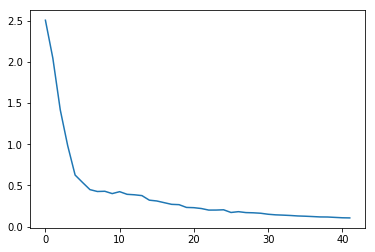

In [145]:
t0 = datetime.now()
costs = []
for i in range(max_iter):
    Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
    for j in range(n_batches):
        Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
        Ybatch = Ytrain[j*batch_sz:(j*batch_sz + batch_sz),]

        train(Xbatch, Ybatch)
        if j % print_period == 0:
            cost_val, prediction_val = get_prediction(Xtest, Ytest)
            err = error_rate(prediction_val, Ytest)
            print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, cost_val, err))
            costs.append(cost_val)
print("Elapsed time:", (datetime.now() - t0))
plt.plot(costs)
plt.show()